## Baseline

### Imports

In [4]:
!pip install datasets
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qudta1k1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qudta1k1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/

In [1]:
import torch
from torch import nn
from datasets import load_dataset
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image
import clip
from tqdm import tqdm

### Data preparation

In [79]:
num_samples = 10
dataset = load_dataset("vinesmsuic/GenAI-Bench_image_edition_processed")
dataset = dataset['train']

def get_preferred_image(row):
    if row['vote_type'] == 'rightvote':
        return row['right_output_image']
    else:
        return row['left_output_image']

def is_valid_size(image, size=(512, 512)):
    """Check if image has the required dimensions"""
    return image.size == size

valid_indices = []
for idx, item in enumerate(dataset):
    source_img = item['source_image']
    preferred_img = get_preferred_image(item)

    if is_valid_size(source_img) and is_valid_size(preferred_img):
        valid_indices.append(idx)

dataset = dataset.select(valid_indices)
dataset = dataset.select(range(num_samples))

dataset = {
    'source_image': dataset['source_image'],
    'target_prompt': dataset['target_prompt'],
    'source_prompt': dataset['source_prompt'],
    'instruct_prompt': dataset['instruct_prompt'],
    'target_image': [get_preferred_image(row) for row in dataset],
    'vote_type': dataset['vote_type'],
    'preference': dataset['preferences']
}

### Model Setup

In [80]:
model_name = "CompVis/stable-diffusion-v1-4"
stable_diffusion = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to("cuda")

clip_model, clip_preprocess = clip.load("ViT-B/32", device="cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Baseline Generation and Evaluation

In [81]:
generated_images = []

for prompt, src_image in tqdm(zip(dataset['target_prompt'], dataset['source_image']), total=len(dataset['target_prompt'])):
    images = stable_diffusion(
        prompt,
        heihht=src_image.size[0],
        width=src_image.size[1],
        num_inference_steps=50,
        guidance_scale=7.5,
        progress_bar=False).images
    generated_images.extend(images)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:09,  7.69s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:15<01:01,  7.68s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:23<00:54,  7.73s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:31<00:46,  7.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:38<00:39,  7.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:46<00:31,  7.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:55<00:23,  7.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 8/10 [01:03<00:15,  7.98s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [01:11<00:07,  7.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:18<00:00,  7.89s/it]


In [82]:
def compute_ssim(img1, img2):
    """Compute SSIM between two images"""
    # Convert PIL images to numpy arrays
    img1_np = np.array(img1.convert('L'))
    img2_np = np.array(img2.convert('L'))

    return ssim(img1_np, img2_np)

In [83]:
def compute_clip_similarity_img2img(clip_model, clip_preprocess, img1, img2):
    """Compute CLIP similarity between images or image and text"""
    # Image to image clip similarity
    img1_processed = clip_preprocess(img1).unsqueeze(0).to("cuda")
    img2_processed = clip_preprocess(img2).unsqueeze(0).to("cuda")

    with torch.no_grad():
        img1_features = clip_model.encode_image(img1_processed)
        img2_features = clip_model.encode_image(img2_processed)
        similarity = torch.cosine_similarity(img1_features, img2_features).item()

    return similarity

def compute_clip_similarity_img2text(clip_model, clip_preprocess, img, text):
    # Image to text clip similarity
    img_processed = clip_preprocess(img).unsqueeze(0).to("cuda")
    text_tokens = clip.tokenize([text]).to("cuda")
    with torch.no_grad():
        img_features = clip_model.encode_image(img_processed)
        text_features = clip_model.encode_text(text_tokens)
        similarity = torch.cosine_similarity(img_features, text_features).item()

    return similarity

In [84]:
metrics = {
    'ssim_scores': [],
    'clip_img2img_target_scores': [],
    'clip_img2img_source_scores': [],
    'clip_img2text_target_scores': [],
    'clip_img2text_source_scores': [],
}

for gen_img, source_img, source_prompt, target_img, target_prompt in zip(generated_images, dataset['source_image'], dataset['source_prompt'], dataset['target_image'], dataset['target_prompt']):
    # Compute SSIM
    ssim_score = compute_ssim(gen_img, target_img)
    metrics['ssim_scores'].append(ssim_score)

    # Compute CLIP similarities
    metrics['clip_img2img_target_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, target_img))
    metrics['clip_img2img_source_scores'].append(compute_clip_similarity_img2img(clip_model, clip_preprocess, gen_img, source_img))
    metrics['clip_img2text_target_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, target_prompt))
    metrics['clip_img2text_source_scores'].append(compute_clip_similarity_img2text(clip_model, clip_preprocess, gen_img, source_prompt))

In [85]:
for metric_name, scores in metrics.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric_name}:\t{mean_score:.4f} (±{std_score:.4f})")

ssim_scores:	0.1863 (±0.0703)
clip_img2img_target_scores:	0.7277 (±0.1424)
clip_img2img_source_scores:	0.6639 (±0.1376)
clip_img2text_target_scores:	0.3234 (±0.0260)
clip_img2text_source_scores:	0.2908 (±0.0249)


## DDIM Inversion

### Implementation

In [150]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from PIL import Image
import torch.nn.functional as F
from tqdm.auto import tqdm

class DDIMInversion:
    def __init__(self):
        pass

    def preprocess_image(self, image):
        """Preprocess image for VAE input"""
        if isinstance(image, Image.Image):
            image = image.resize((512, 512))
            image = torch.from_numpy(np.array(image)).float() / 127.5 - 1
            image = image.to(dtype=torch.float16)
            image = image.permute(2, 0, 1).unsqueeze(0).to("cuda")
        return image

    def encode_images(self, pipeline, images):
        """Encode images to latent space"""
        with torch.no_grad():
            latents = pipeline.vae.encode(images).latent_dist.sample()
            latents = latents * 0.18215
        return latents

    def ddim_inversion(self, pipeline, image, prompt, num_inference_steps=50):
        """Perform DDIM inversion to get latents"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Preprocess and encode image
        image = self.preprocess_image(image)
        latents = self.encode_images(pipeline, image)

        # Get text embeddings
        text_embeddings = pipeline._encode_prompt(
            prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Initialize timesteps
        timesteps = pipeline.scheduler.timesteps.flip(0)

        # DDIM inversion
        print("Performing DDIM inversion...")
        for t in tqdm(timesteps):
            # Expand latents for classifier free guidance
            latent_model_input = torch.cat([latents] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            # DDIM reverse step
            latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

        return latents

    def regenerate_with_target(self, pipeline, latents, target_prompt, num_inference_steps=50):
        """Generate new image from inverted latents using target prompt"""
        pipeline.scheduler.set_timesteps(num_inference_steps)

        # Get text embeddings for target prompt
        text_embeddings = pipeline._encode_prompt(
            target_prompt,
            device="cuda",
            num_images_per_prompt=1,
            do_classifier_free_guidance=True
        )

        # Generation loop
        print("Generating with target prompt...")
        for t in tqdm(pipeline.scheduler.timesteps):
            # Expand latents for classifier free guidance
            latent_model_input = torch.cat([latents] * 2)

            # Predict noise
            with torch.no_grad():
                noise_pred = pipeline.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=text_embeddings
                ).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + 7.5 * (noise_pred_text - noise_pred_uncond)

            # DDIM step
            latents = pipeline.scheduler.step(
                noise_pred,
                t,
                latents
            ).prev_sample

        # Decode latents to image
        with torch.no_grad():
            latents = 1 / 0.18215 * latents
            image = pipeline.vae.decode(latents).sample

        # Postprocess image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        image = (image * 255).round().astype("uint8")
        image = Image.fromarray(image[0])

        return image

# Example usage
def edit_image(pipeline, source_image, source_prompt, target_prompt):
    """Edit image using DDIM inversion and target prompt"""
    # Initialize model
    ddim_inv = DDIMInversion()

    # Perform inversion
    inverted_latents = ddim_inv.ddim_inversion(pipeline, source_image, source_prompt)

    # Generate with target prompt
    edited_image = ddim_inv.regenerate_with_target(pipeline, inverted_latents, target_prompt)

    return edited_image

Outdoor show with sheep prominent on grass field.
Outdoor show with black sheep prominent on grass field.


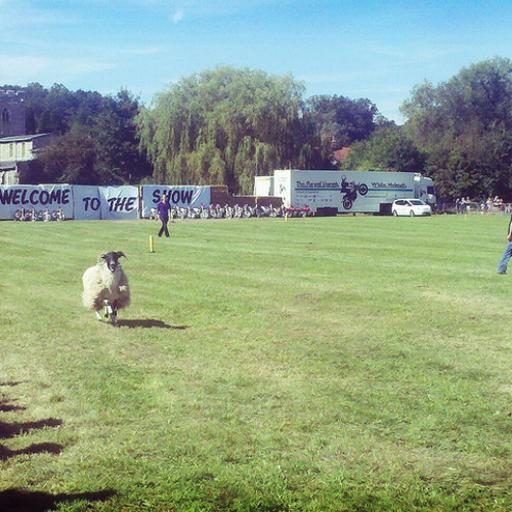

In [151]:
idx = 9
source_image  = dataset['source_image'][idx]
target_image  = dataset['target_image'][idx]
source_prompt = dataset['source_prompt'][idx]
target_prompt = dataset['target_prompt'][idx]

print(source_prompt)
print(target_prompt)
source_image

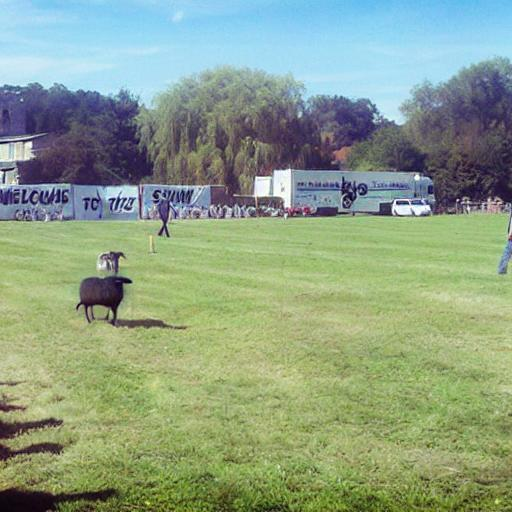

In [152]:
target_image

In [153]:
model_name = "CompVis/stable-diffusion-v1-4"
stable_diffusion = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16
).to("cuda")

stable_diffusion.vae.requires_grad_(False)
stable_diffusion.text_encoder.requires_grad_(False)
stable_diffusion.unet.requires_grad_(False)
None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [154]:
gen_image = edit_image(stable_diffusion, source_image, source_prompt, target_prompt)

Performing DDIM inversion...


  0%|          | 0/51 [00:00<?, ?it/s]

Generating with target prompt...


  0%|          | 0/51 [00:00<?, ?it/s]

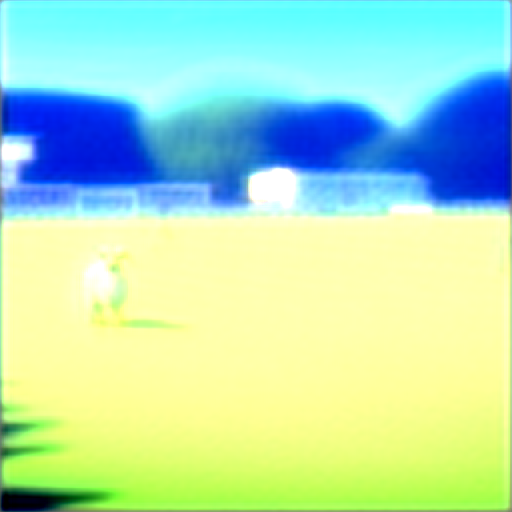

In [155]:
gen_image